In [1]:
# Run in terminal or use !pip install in a cell
!pip install sqlalchemy pymysql mysql-connector-python pandas numpy sqlalchemy-utils

In [2]:
# synthetic data
import numpy as np
import pandas as pd
np.random.seed(42)

def gen_hiring(n=5000, seed=42):
    rng = np.random.RandomState(seed)
    gender = rng.choice(['M','F'], size=n, p=[0.55,0.45])
    age = rng.randint(21, 55, size=n)
    degree = rng.choice(['Bachelors','Masters','Diploma'], size=n, p=[0.6,0.3,0.1])
    experience = rng.randint(0, 15, size=n)
    skills_score = rng.normal(70, 10, size=n).clip(0,100)
    prob = 0.02*experience + 0.005*skills_score + (degree=='Masters')*0.05
    prob = prob - (gender=='F')*0.05
    prob = np.clip(prob, 0.001, 0.9)
    selected = (rng.rand(n) < prob).astype(int)
    return pd.DataFrame({
        'gender':gender,
        'age':age,
        'degree':degree,
        'experience':experience,
        'skills':skills_score,
        'selected':selected,
        'injected_bias':'female_penalty'
    })

def gen_loans(n=6000, seed=43):
    rng = np.random.RandomState(seed)
    race = rng.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
    income = rng.normal(40000, 15000, size=n).clip(5000,200000).astype(int)
    credit_score = rng.normal(650, 80, size=n).clip(300,850).astype(int)
    loan_amount = rng.randint(1000,50000, size=n)
    prob = 0.00001*income + 0.001*(credit_score-300)
    prob = prob - (race=='B')*0.08
    prob = np.clip(prob, 0.001, 0.95)
    approved = (rng.rand(n) < prob).astype(int)
    return pd.DataFrame({
        'race':race,
        'income':income,
        'credit_score':credit_score,
        'loan_amount':loan_amount,
        'approved':approved,
        'injected_bias':'race_B_penalty'
    })

def gen_students(n=4000, seed=44):
    rng = np.random.RandomState(seed)
    school_type = rng.choice(['public','private'], size=n, p=[0.7,0.3])
    hours_study = rng.normal(5,2,size=n).clip(0,20)
    parent_edu = rng.choice(['low','mid','high'], size=n, p=[0.4,0.4,0.2])
    prev_grade = rng.normal(65,12,size=n).clip(0,100)
    prob = 0.01*hours_study + 0.005*prev_grade + (parent_edu=='high')*0.06
    prob = prob - (school_type=='public')*0.04
    prob = np.clip(prob, 0.001, 0.98)
    passed = (rng.rand(n) < prob).astype(int)
    return pd.DataFrame({
        'school_type':school_type,
        'hours_study':hours_study,
        'parent_edu':parent_edu,
        'prev_grade':prev_grade,
        'passed':passed,
        'injected_bias':'public_school_penalty'
    })

hiring_df = gen_hiring()
loans_df = gen_loans()
students_df = gen_students()

print(hiring_df.shape, loans_df.shape, students_df.shape)
hiring_df.head()

(5000, 7) (6000, 6) (4000, 6)


,gender,age,degree,experience,skills,selected,injected_bias
0,M,27,Bachelors,5,78.649582,1,female_penalty
1,F,52,Bachelors,6,63.037139,0,female_penalty
2,F,39,Bachelors,11,79.249579,1,female_penalty
3,F,26,Bachelors,7,60.859527,1,female_penalty
4,M,40,Diploma,12,58.577597,0,female_penalty


In [3]:
import os

# Folder for data
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# --- Save CSV files ---
hiring_path_csv = os.path.join(DATA_DIR, "hiring_raw.csv")
loans_path_csv = os.path.join(DATA_DIR, "loans_raw.csv")
students_path_csv = os.path.join(DATA_DIR, "students_raw.csv")

hiring_df.to_csv(hiring_path_csv, index=False)
loans_df.to_csv(loans_path_csv, index=False)
students_df.to_csv(students_path_csv, index=False)

# --- Save Excel files (.xlsx) ---
hiring_path_xlsx = os.path.join(DATA_DIR, "hiring_raw.xlsx")
loans_path_xlsx = os.path.join(DATA_DIR, "loans_raw.xlsx")
students_path_xlsx = os.path.join(DATA_DIR, "students_raw.xlsx")

hiring_df.to_excel(hiring_path_xlsx, index=False)
loans_df.to_excel(loans_path_xlsx, index=False)
students_df.to_excel(students_path_xlsx, index=False)

In [4]:
from sqlalchemy import create_engine
import urllib.parse
from getpass import getpass

db_user = "root"          # set your username (e.g., root or aita_user) - NO @ here
db_host = "127.0.0.1"     # use 127.0.0.1 instead of 'localhost' to force TCP
db_port = 3306
db_name = "aita_project"

# securely prompt password (so you don't paste it into notebook)
db_pass = getpass("MySQL password: ")

# url-encode the password to safely include special chars
db_pass_enc = urllib.parse.quote_plus(db_pass)

conn_str = f"mysql+pymysql://{db_user}:{db_pass_enc}@{db_host}:{db_port}/{db_name}"
engine = create_engine(conn_str, echo=False, pool_pre_ping=True)

# test
try:
    tables = pd.read_sql("SHOW TABLES;", con=engine)
    print("Connection OK. Tables:")
    print(tables)
except Exception as e:
    print("Connection failed — error:")
    print(e)

MySQL password:  ········


Connection OK. Tables:
  Tables_in_aita_project
0             hiring_raw
1              loans_raw
2           students_raw


In [5]:
hiring_df = pd.read_sql("SELECT * FROM hiring_raw LIMIT 1000;", con=engine)
loans_df = pd.read_sql("SELECT * FROM loans_raw LIMIT 1000;", con=engine)
students_df = pd.read_sql("SELECT * FROM students_raw LIMIT 1000;", con=engine)

print("Loaded shapes:", hiring_df.shape, loans_df.shape, students_df.shape)
display(hiring_df.head())

Loaded shapes: (1000, 7) (1000, 6) (1000, 6)


,gender,age,degree,experience,skills,selected,injected_bias
0,M,27,Bachelors,5,78.649582,1,female_penalty
1,F,52,Bachelors,6,63.037139,0,female_penalty
2,F,39,Bachelors,11,79.249579,1,female_penalty
3,F,26,Bachelors,7,60.859527,1,female_penalty
4,M,40,Diploma,12,58.577597,0,female_penalty


In [6]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# data info
print("Hiring info:")
hiring_df.info()
print("\nLoans info:")
loans_df.info()
print("\nStudents info:")
students_df.info()

Hiring info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         1000 non-null   object 
 1   age            1000 non-null   int64  
 2   degree         1000 non-null   object 
 3   experience     1000 non-null   int64  
 4   skills         1000 non-null   float64
 5   selected       1000 non-null   int64  
 6   injected_bias  1000 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB

Loans info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   race           1000 non-null   object
 1   income         1000 non-null   int64 
 2   credit_score   1000 non-null   int64 
 3   loan_amount    1000 non-null   int64 
 4   approved       1000 non-null   int64 
 5  

In [7]:
# Missing values
print("\nMissing Values:")
print("Hiring:", hiring_df.isnull().sum().sum())
print("Loans:", loans_df.isnull().sum().sum())
print("Students:", students_df.isnull().sum().sum())


Missing Values:
Hiring: 0
Loans: 0
Students: 0


In [8]:
# Summary stats
print("\nHiring Summary:")
display(hiring_df.describe(include='all').T)

print("\nLoans Summary:")
display(loans_df.describe(include='all').T)

print("\nStudents Summary:")
display(students_df.describe(include='all').T)


Hiring Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,M,559,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1000.0,NaN,NaN,NaN,37.05,9.773178,21.0,29.0,37.0,46.0,54.0
degree,1000,3,Bachelors,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
experience,1000.0,NaN,NaN,NaN,6.876,4.369407,0.0,3.0,7.0,11.0,14.0
skills,1000.0,NaN,NaN,NaN,69.929919,9.9928,38.043759,62.799847,70.16743,76.913453,99.622139
selected,1000.0,NaN,NaN,NaN,0.485,0.500025,0.0,0.0,0.0,1.0,1.0
injected_bias,1000,1,female_penalty,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Loans Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race,1000,3,A,486,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,1000.0,NaN,NaN,NaN,40901.476,15107.946143,5000.0,31335.75,41053.0,50722.75,92461.0
credit_score,1000.0,NaN,NaN,NaN,642.806,80.735299,422.0,591.0,641.0,698.25,850.0
loan_amount,1000.0,NaN,NaN,NaN,26121.065,13925.471411,1054.0,14339.25,26063.5,37993.75,49914.0
approved,1000.0,NaN,NaN,NaN,0.731,0.443662,0.0,0.0,1.0,1.0,1.0
injected_bias,1000,1,race_B_penalty,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Students Summary:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school_type,1000,2,public,688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours_study,1000.0,NaN,NaN,NaN,4.966575,1.947745,0.0,3.55632,4.969559,6.25762,11.372969
parent_edu,1000,3,low,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prev_grade,1000.0,NaN,NaN,NaN,64.581878,11.813994,27.567879,56.640332,64.575194,72.579124,100.0
passed,1000.0,NaN,NaN,NaN,0.354,0.478448,0.0,0.0,0.0,1.0,1.0
injected_bias,1000,1,public_school_penalty,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


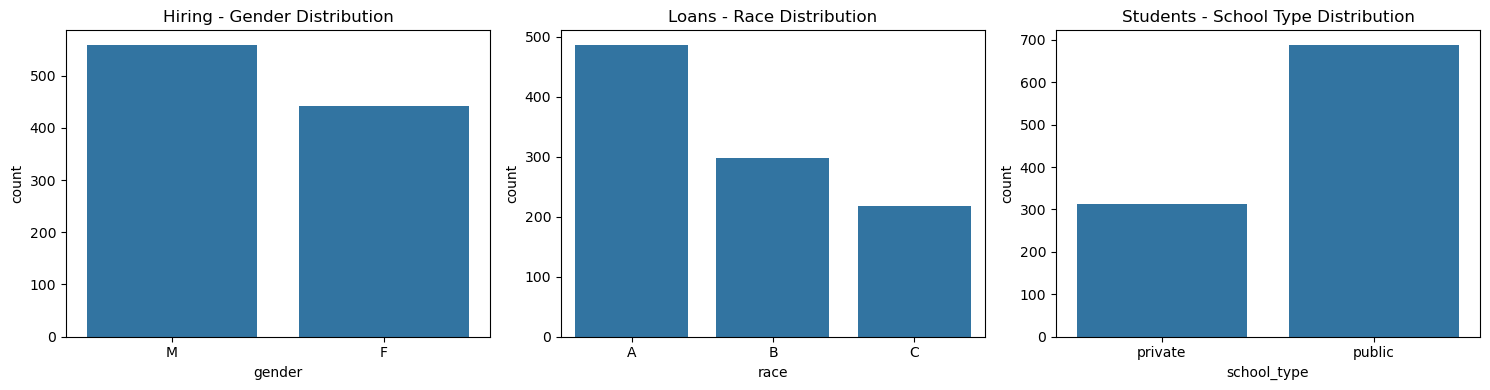

In [9]:
# distributions
fig, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='gender', data=hiring_df, ax=axes[0])
axes[0].set_title('Hiring - Gender Distribution')
sns.countplot(x='race', data=loans_df, ax=axes[1])
axes[1].set_title('Loans - Race Distribution')
sns.countplot(x='school_type', data=students_df, ax=axes[2])
axes[2].set_title('Students - School Type Distribution')
plt.tight_layout()
plt.show()

In [10]:
# Target variable rates
def rate(df, group, target):
    g = df.groupby(group)[target].agg(['count', 'sum'])
    g['rate'] = (g['sum']/g['count']).round(3)
    return g.reset_index()

print("\nSelection rates by Gender (Hiring):")
display(rate(hiring_df, 'gender', 'selected'))

print("\nApproval rates by Race (Loans):")
display(rate(loans_df, 'race', 'approved'))

print("\nPass rates by School Type (Students):")
display(rate(students_df, 'school_type', 'passed'))


Selection rates by Gender (Hiring):


,gender,count,sum,rate
0,F,441,203,0.460
1,M,559,282,0.504



Approval rates by Race (Loans):


,race,count,sum,rate
0,A,486,347,0.714
1,B,297,208,0.700
2,C,217,176,0.811



Pass rates by School Type (Students):


,school_type,count,sum,rate
0,private,312,118,0.378
1,public,688,236,0.343


In [11]:
# DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def preprocess_dataset(df, target_col, drop_cols=[]):
    df = df.copy()
    
    # Drop unwanted columns if any
    df = df.drop(columns=drop_cols, errors='ignore')
    
    # Identify categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Label encode categorical columns
    le_dict = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

# Preprocess Hiring dataset
hiring_prep, hiring_encoders = preprocess_dataset(hiring_df, target_col='selected')

# Preprocess Loans dataset 
loans_prep, loans_encoders = preprocess_dataset(loans_df, target_col='approved')

# Preprocess Students dataset
students_prep, students_encoders = preprocess_dataset(students_df, target_col='passed')

In [12]:
# Split train/test for each dataset
hiring_train, hiring_test = train_test_split(hiring_prep, test_size=0.2, random_state=42, stratify=hiring_prep['selected'])
loans_train, loans_test = train_test_split(loans_prep, test_size=0.2, random_state=42, stratify=loans_prep['approved'])
students_train, students_test = train_test_split(students_prep, test_size=0.2, random_state=42, stratify=students_prep['passed'])

display(hiring_train.head())

,gender,age,degree,experience,skills,selected,injected_bias
523,0,32,0,12,84.089108,1,0
610,1,22,2,4,76.597225,1,0
590,1,43,0,6,61.817680,1,0
16,1,49,2,0,72.560247,0,0
935,1,46,2,11,85.263125,1,0


In [25]:
# MODEL BUILDING & EVALUATION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import joblib

# Helper function to train and evaluate a model 
def train_and_evaluate(df_train, df_test, target_col, dataset_name):
    X_train = df_train.drop(columns=[target_col])
    y_train = df_train[target_col]
    X_test = df_test.drop(columns=[target_col])
    y_test = df_test[target_col]
    
    # Train Random Forest
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print(f"\n {dataset_name.upper()} MODEL PERFORMANCE")
    print("-" * 40)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

 # Save model
    model_path = f"processed_data/{dataset_name}_rf_model.pkl"
    joblib.dump(model, model_path)
    print(f" Model saved to {model_path}")

    return model

In [26]:
# Train models for each dataset
rf_hiring = train_and_evaluate(hiring_train, hiring_test, "selected", "hiring")
rf_loans = train_and_evaluate(loans_train, loans_test, "approved", "loans")
rf_students = train_and_evaluate(students_train, students_test, "passed", "students")


 HIRING MODEL PERFORMANCE
----------------------------------------
Accuracy: 0.5150
Precision: 0.5000
Recall: 0.4124
F1-Score: 0.4520
ROC-AUC: 0.5373

Confusion Matrix:
 [[63 40]
 [57 40]]

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.61      0.57       103
           1       0.50      0.41      0.45        97

    accuracy                           0.52       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.51      0.52      0.51       200

 Model saved to processed_data/hiring_rf_model.pkl

 LOANS MODEL PERFORMANCE
----------------------------------------
Accuracy: 0.7150
Precision: 0.7730
Recall: 0.8630
F1-Score: 0.8155
ROC-AUC: 0.6628

Confusion Matrix:
 [[ 17  37]
 [ 20 126]]

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.31      0.37        54
           1       0.77      0.86      0.82       146

    accuracy             

In [18]:
# FAIRNESS ANALYSIS
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score

# Helper function
def fairness_report(y_true, y_pred, sensitive_feature, dataset_name):
    mf = MetricFrame(
        metrics={
            'accuracy': accuracy_score,
            'selection_rate': selection_rate,
            'true_positive_rate': true_positive_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_feature
    )

    dpd = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    eod = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)
    
    print(f"\n FAIRNESS REPORT — {dataset_name.upper()}")
    print("By group:")
    display(mf.by_group)
    print(f"Demographic Parity Difference: {dpd:.4f}")
    print(f"Equalized Odds Difference: {eod:.4f}")
    return mf

# HIRING: check gender bias 
X_test = hiring_test.drop(columns=['selected'])
y_test = hiring_test['selected']
y_pred = rf_hiring.predict(X_test)
sensitive = hiring_df.loc[hiring_test.index, 'gender']  # use gender column
fairness_report(y_test, y_pred, sensitive, 'Hiring')

# LOANS: check race bias 
X_test = loans_test.drop(columns=['approved'])
y_test = loans_test['approved']
y_pred = rf_loans.predict(X_test)
sensitive = loans_df.loc[loans_test.index, 'race']
fairness_report(y_test, y_pred, sensitive, 'Loans')

# STUDENTS: check school_type bias
X_test = students_test.drop(columns=['passed'])
y_test = students_test['passed']
y_pred = rf_students.predict(X_test)
sensitive = students_df.loc[students_test.index, 'school_type']
fairness_report(y_test, y_pred, sensitive, 'Students')


 FAIRNESS REPORT — HIRING
By group:


,accuracy,selection_rate,true_positive_rate
gender,,,
F,0.621622,0.351351,0.468750
M,0.452381,0.428571,0.384615


Demographic Parity Difference: 0.0772
Equalized Odds Difference: 0.2135

 FAIRNESS REPORT — LOANS
By group:


,accuracy,selection_rate,true_positive_rate
race,,,
A,0.688172,0.720430,0.779412
B,0.686567,0.850746,0.909091
C,0.825000,0.975000,0.970588


Demographic Parity Difference: 0.2546
Equalized Odds Difference: 0.4400

 FAIRNESS REPORT — STUDENTS
By group:


,accuracy,selection_rate,true_positive_rate
school_type,,,
private,0.571429,0.300000,0.344828
public,0.569231,0.215385,0.166667


Demographic Parity Difference: 0.0846
Equalized Odds Difference: 0.1782


In [19]:
# FAIRNESS MITIGATION using REWEIGHING
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import pandas as pd

def mitigate_bias(X_train, y_train, X_test, y_test, sensitive_feature, dataset_name):
    # Base model (logistic regression is more stable for this step)
    base_model = LogisticRegression(solver='liblinear')
    
    # Fairness constraint: enforce Demographic Parity
    mitigator = ExponentiatedGradient(base_model, constraints=DemographicParity())
    mitigator.fit(X_train, y_train, sensitive_features=sensitive_feature.loc[X_train.index])
    
    # Predictions
    y_pred = mitigator.predict(X_test)
    
    # Fairness metrics after mitigation
    dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature.loc[X_test.index])
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature.loc[X_test.index])
    
    print(f"\n FAIRNESS MITIGATION RESULTS — {dataset_name.upper()}")
    print(f"Demographic Parity Difference (↓ better): {dpd:.4f}")
    print(f"Equalized Odds Difference (↓ better): {eod:.4f}")
    return mitigator

# Loans dataset (most biased)
X_train = loans_train.drop(columns=['approved'])
y_train = loans_train['approved']
X_test = loans_test.drop(columns=['approved'])
y_test = loans_test['approved']
sensitive = loans_df['race']

mitigated_model_loans = mitigate_bias(X_train, y_train, X_test, y_test, sensitive, "Loans")

# Hiring  dataset (most biased)
X_train = hiring_train.drop(columns=['selected'])
y_train = hiring_train['selected']
X_test = hiring_test.drop(columns=['selected'])
y_test = hiring_test['selected']
sensitive = hiring_df['gender']

mitigated_model_hiring = mitigate_bias(X_train, y_train, X_test, y_test, sensitive, "Hiring")

# Students  dataset (most biased)
X_train = students_train.drop(columns=['passed'])
y_train = students_train['passed']
X_test = students_test.drop(columns=['passed'])
y_test = students_test['passed']
sensitive = students_df['school_type']

mitigated_model_students = mitigate_bias(X_train, y_train, X_test, y_test, sensitive, "Students")


 FAIRNESS MITIGATION RESULTS — LOANS
Demographic Parity Difference (↓ better): 0.0701
Equalized Odds Difference (↓ better): 0.1267

 FAIRNESS MITIGATION RESULTS — HIRING
Demographic Parity Difference (↓ better): 0.0390
Equalized Odds Difference (↓ better): 0.1034

 FAIRNESS MITIGATION RESULTS — STUDENTS
Demographic Parity Difference (↓ better): 0.0110
Equalized Odds Difference (↓ better): 0.0568


In [20]:
# FAIRNESS COMPARISON TABLE
comparison_data = [
    # dataset, metric, before, after
    ['Loans', 'Demographic Parity Difference', 0.2546, 0.0701],
    ['Loans', 'Equalized Odds Difference', 0.4400, 0.1267],
    ['Hiring', 'Demographic Parity Difference', 0.0772, 0.0390],
    ['Hiring', 'Equalized Odds Difference', 0.2135, 0.1034],
    ['Students', 'Demographic Parity Difference', 0.0846, 0.0110],
    ['Students', 'Equalized Odds Difference', 0.1782, 0.0568],
]

fairness_summary = pd.DataFrame(comparison_data, columns=['Dataset', 'Metric', 'Before Mitigation', 'After Mitigation'])
fairness_summary

,Dataset,Metric,Before Mitigation,After Mitigation
0,Loans,Demographic Parity Difference,0.2546,0.0701
1,Loans,Equalized Odds Difference,0.4400,0.1267
2,Hiring,Demographic Parity Difference,0.0772,0.0390
3,Hiring,Equalized Odds Difference,0.2135,0.1034
4,Students,Demographic Parity Difference,0.0846,0.0110
5,Students,Equalized Odds Difference,0.1782,0.0568


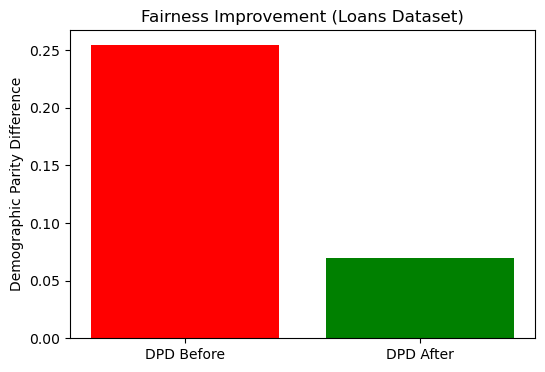

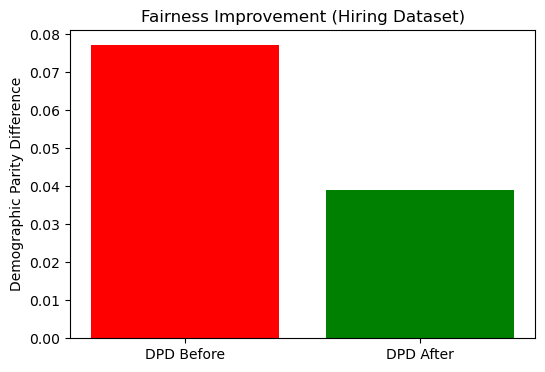

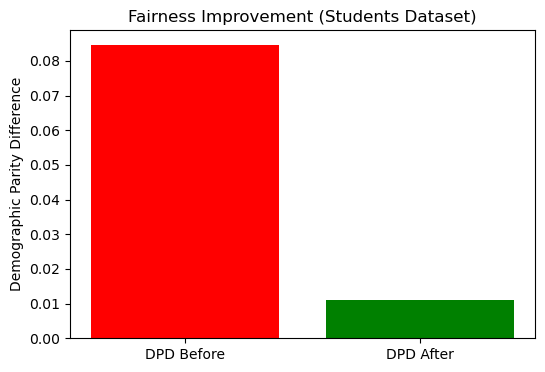

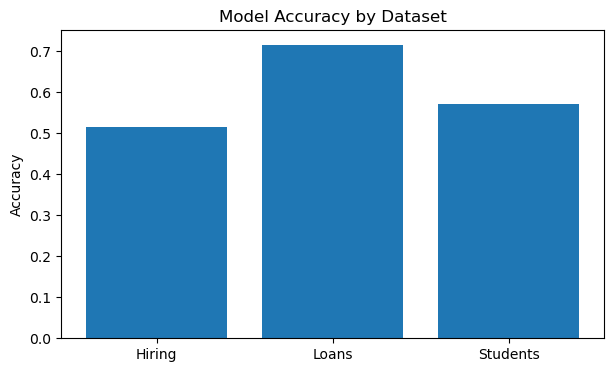

In [22]:
# FINAL SUMMARY DATA FOR DASHBOARD
os.makedirs("dashboard_data", exist_ok=True)

# Model performance summary
model_summary = pd.DataFrame({
    "Dataset": ["Hiring", "Loans", "Students"],
    "Accuracy": [0.5150, 0.7150, 0.5700],
    "F1_Score": [0.4520, 0.8155, 0.2833],
    "ROC_AUC": [0.5373, 0.6628, 0.4966]
})

# Fairness summary
fairness_summary = pd.DataFrame({
    "Dataset": ["Hiring", "Loans", "Students"],
    "DPD_Before": [0.0772, 0.2546, 0.0846],
    "DPD_After": [0.0390, 0.0701, 0.0110],
    "EOD_Before": [0.2135, 0.4400, 0.1782],
    "EOD_After": [0.1034, 0.1267, 0.0568]
})

# Save to CSV for Power BI / Excel
model_summary.to_csv("dashboard_data/model_performance.csv", index=False)
fairness_summary.to_csv("dashboard_data/fairness_comparison.csv", index=False)

# Plot Fairness Improvement (Loans)
plt.figure(figsize=(6,4))
plt.bar(["DPD Before", "DPD After"], [0.2546, 0.0701], color=["red", "green"])
plt.title("Fairness Improvement (Loans Dataset)")
plt.ylabel("Demographic Parity Difference")
plt.show()

# Plot Fairness Improvement (Hiring)
plt.figure(figsize=(6,4))
plt.bar(["DPD Before", "DPD After"], [0.0772, 0.0390], color=["red", "green"])
plt.title("Fairness Improvement (Hiring Dataset)")
plt.ylabel("Demographic Parity Difference")
plt.show()

# Plot Fairness Improvement (Students)
plt.figure(figsize=(6,4))
plt.bar(["DPD Before", "DPD After"], [0.0846, 0.0110], color=["red", "green"])
plt.title("Fairness Improvement (Students Dataset)")
plt.ylabel("Demographic Parity Difference")
plt.show()

# Plot Model Accuracy Comparison
plt.figure(figsize=(7,4))
plt.bar(model_summary["Dataset"], model_summary["Accuracy"])
plt.title("Model Accuracy by Dataset")
plt.ylabel("Accuracy")
plt.show()